In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from src.few_shot_learning import load_cinic10, calculate_accuracy, plot_confusion_matrix

class FewShotResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FewShotResNet, self).__init__()
        self.backbone = models.resnet18(weights="IMAGENET1K_V1")  # Load pretrained model
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)  # Replace last layer
    
    def forward(self, x):
        return self.backbone(x)

In [6]:
torch.hub.set_dir("../../models")

In [29]:
def train_few_shot(model, dataloader, epochs=10, lr=0.001):
    for param in model.backbone.parameters():
        param.requires_grad = False  # Freeze all layers

    for param in model.backbone.layer4.parameters():
        param.requires_grad = True # The results were worse without freezing this layer
    for param in model.backbone.fc.parameters():
        param.requires_grad = True  # Unfreeze final classifier
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in dataloader:  # Load few-shot dataset
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

In [30]:
data_dir = "../../data"
dataloader = load_cinic10(data_dir, few_shot_per_class=100)
model = FewShotResNet()
train_few_shot(model, dataloader, epochs=30)

Epoch [1/30], Loss: 150.6905
Epoch [2/30], Loss: 98.0676
Epoch [3/30], Loss: 75.6621
Epoch [4/30], Loss: 64.8389
Epoch [5/30], Loss: 52.8943
Epoch [6/30], Loss: 50.5121
Epoch [7/30], Loss: 45.2414
Epoch [8/30], Loss: 37.4036
Epoch [9/30], Loss: 32.7374
Epoch [10/30], Loss: 29.9979
Epoch [11/30], Loss: 25.7097
Epoch [12/30], Loss: 26.0231
Epoch [13/30], Loss: 24.1563
Epoch [14/30], Loss: 23.8426
Epoch [15/30], Loss: 25.8135
Epoch [16/30], Loss: 20.7283
Epoch [17/30], Loss: 18.8456
Epoch [18/30], Loss: 20.3004
Epoch [19/30], Loss: 19.2763
Epoch [20/30], Loss: 15.5817
Epoch [21/30], Loss: 16.0514
Epoch [22/30], Loss: 16.6286
Epoch [23/30], Loss: 17.2962
Epoch [24/30], Loss: 13.6320
Epoch [25/30], Loss: 13.9060
Epoch [26/30], Loss: 9.1162
Epoch [27/30], Loss: 15.2998
Epoch [28/30], Loss: 17.2579
Epoch [29/30], Loss: 17.4923
Epoch [30/30], Loss: 16.3016


In [31]:
train_accuracy = calculate_accuracy(model, data_dir, split='train')

Accuracy on train set: 35.51%


In [32]:
test_accuracy = calculate_accuracy(model, data_dir, split='test')

Accuracy on test set: 34.75%


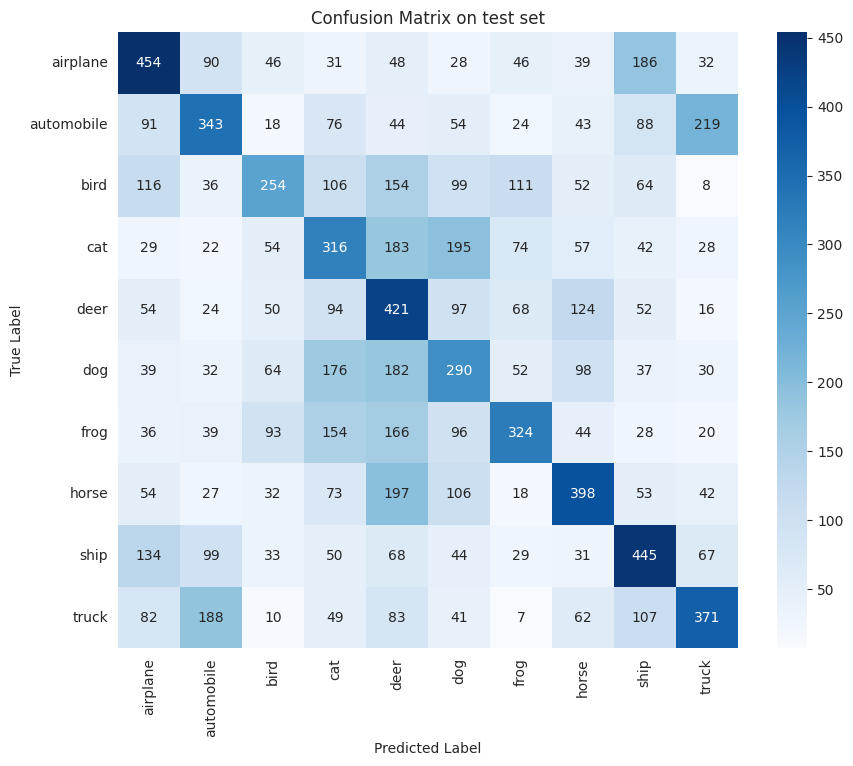

In [33]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
lot_confusion_matrix(model, data_dir, split='test', class_names=class_names)

In [38]:
import torch.nn.functional as F
class CosineClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_classes, in_features))  # Class prototypes

    def forward(self, x):
        x = F.normalize(x, dim=1)
        w = F.normalize(self.weights, dim=1)
        return torch.mm(x, w.T)  # Cosine similarity
model = FewShotResNet()
model.backbone.fc = CosineClassifier(model.backbone.fc.in_features, 10)
train_few_shot(model, dataloader, epochs=30)

Epoch [1/30], Loss: 137.6969
Epoch [2/30], Loss: 127.9851
Epoch [3/30], Loss: 123.0888
Epoch [4/30], Loss: 119.4327
Epoch [5/30], Loss: 115.7609
Epoch [6/30], Loss: 113.7746
Epoch [7/30], Loss: 111.8639
Epoch [8/30], Loss: 110.9717
Epoch [9/30], Loss: 109.8677
Epoch [10/30], Loss: 109.8452
Epoch [11/30], Loss: 108.1073
Epoch [12/30], Loss: 107.2252
Epoch [13/30], Loss: 106.7304
Epoch [14/30], Loss: 105.9499
Epoch [15/30], Loss: 104.9058
Epoch [16/30], Loss: 105.6510
Epoch [17/30], Loss: 104.1706
Epoch [18/30], Loss: 104.1587
Epoch [19/30], Loss: 104.0078
Epoch [20/30], Loss: 103.4242
Epoch [21/30], Loss: 103.1559
Epoch [22/30], Loss: 102.1804
Epoch [23/30], Loss: 101.9149
Epoch [24/30], Loss: 102.0970
Epoch [25/30], Loss: 101.5097
Epoch [26/30], Loss: 101.2824
Epoch [27/30], Loss: 100.9233
Epoch [28/30], Loss: 100.7850
Epoch [29/30], Loss: 100.2996
Epoch [30/30], Loss: 100.4750


Cosine Classifier doesn't help I guess